In [32]:
import tensorflow as tf
import edward as ed
import numpy as np
import seaborn as sns
import pandas as pd

from edward.models import Normal

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('seaborn')

In [2]:
train_data = pd.read_csv('train.csv')

In [6]:
# Isolate and log-transform all numeric data
numeric_data = train_data.dtypes[train_data.dtypes != 'object'].index
skewed = train_data[numeric_data].apply(lambda x: skew(x.dropna()))
skewed = skewed[skewed > 0.75].index
train_data[skewed] = np.log1p(train_data[skewed])

In [7]:
# Apparently this gets "dummy data" for categorical data
train_data = pd.get_dummies(train_data) # this is pretty sick

In [9]:
# fill nansies
train_data = train_data.fillna(train_data.mean())

In [177]:
X_train = scale(train_data.drop('SalePrice', axis=1))
prices = scale(train_data['SalePrice'])

In [178]:
N = X_train.shape[0] # number of data points
D = X_train.shape[1] # number of features

In [219]:
# modelus
def neural_network(x):
    h = tf.tanh(tf.matmul(x, W0) + b0)
    h = tf.tanh(tf.matmul(h, W1) + b1)
    h = (tf.matmul(h, W2) + b2)
    return tf.reshape(h, [-1])

h1Size = 10 # hidden layer size
h2Size = 2 # 2nd layer size

W0 = Normal(loc=tf.zeros([D, h1Size]), scale=tf.ones([D, h1Size]))
W1 = Normal(loc=tf.zeros([h1Size, h2Size]), scale=tf.ones([h1Size, h2Size]))
W2 = Normal(loc=tf.zeros([h2Size, 1]), scale=tf.ones([h2Size, 1]))
b0 = Normal(loc=tf.zeros([h1Size]), scale=tf.ones([h1Size]))
b1 = Normal(loc=tf.zeros([h2Size]), scale=tf.ones([h2Size]))
b2 = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

x = tf.cast(X_train, tf.float32)
y = Normal(loc=neural_network(x), scale=0.1*tf.ones(1))

In [220]:
qW0 = Normal(loc=tf.Variable(tf.zeros([D, h1Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([D, h1Size]))))
qW1 = Normal(loc=tf.Variable(tf.zeros([h1Size, h2Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h1Size, h2Size]))))
qW2 = Normal(loc=tf.Variable(tf.zeros([h2Size, 1])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h2Size, 1]))))
qb0 = Normal(loc=tf.Variable(tf.zeros([h1Size])), 
             scale=tf.nn.softplus(tf.Variable(tf.ones([h1Size]))))
qb1 = Normal(loc=tf.Variable(tf.zeros([h2Size])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([h2Size]))))
qb2 = Normal(loc=tf.Variable(tf.zeros([1])),
             scale=tf.nn.softplus(tf.Variable(tf.ones([1]))))

In [212]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)


In [213]:
latent_vars = {
    W0: qW0, W1: qW1, W2: qW2,
    b0: qb0, b1: qb1, b2: qb2
}

y_ph = tf.placeholder(tf.float32, shape=None)
X = tf.placeholder(tf.float32, shape=[None, D])
batch_size = 20

In [214]:
inference = ed.KLqp(latent_vars)
inference.initialize(n_samples=10)
tf.global_variables_initializer().run()

In [215]:
train_length = 1000
for ind in range(train_length):
    start = np.mod((ind-1)*batch_size+1,N)
    fin =  np.mod((ind)*batch_size,N)
    X_batch = X_train[start:fin, :]
    y_batch = prices[start:fin]
    info_dict = inference.update()
    inference.print_progress(info_dict)

1000/1000 [100%] ██████████████████████████████ Elapsed: 31s | Loss: -0.000


In [216]:
yp = ed.copy(y, latent_vars)

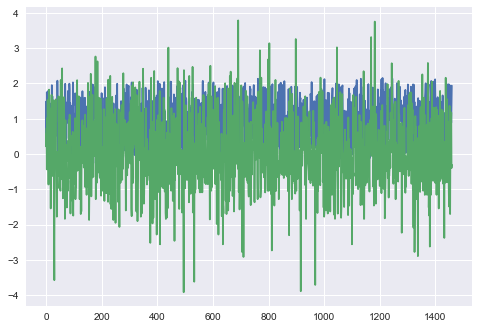

In [217]:
plt.plot(yp.eval())
plt.plot(prices)

In [218]:
print(ed.evaluate('mse', data={X: X_train, yp: np.asarray(prices)}))

1.01038


In [128]:
def visualize_data_fit(X, y, B, A, title_prefix, n_samples=10):
    B_samples = B.sample(n_samples).eval()
    A_samples = A.sample(n_samples).eval()
    
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * B_samples[i][0] + inputs*B_samples[i][1]
        ax.plot(inputs, inputs, output)

In [ ]:
visualize_data_fit(X_train, y_train, qB_fixed_effects, qA, 'Posterior', n_samples=10)

In [139]:
next?